In [1]:
import os
import sys
import glob
import yaml
import pickle
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, LabelEncoder

## config

In [2]:
# config
with open('config.yaml') as f:
    config = yaml.safe_load(f)

# globals variable
SEED = config['globals']['seed']
MAX_EPOCHS = config['globals']['max_epochs']
N_SPLITS = config['globals']['n_splits']
USE_FOLDS = config['globals']['use_folds']
DEBUG = config['globals']['debug']
EXP_MESSAGE = config['globals']['exp_message']
NOTES = config['globals']['notes']
MODEL_SAVE = config['globals']['model_save']
ONLY_PRED = config['globals']['only_pred']
PRETRAINED = config['globals']['pretrained']
PRETRAINED_PATH = config['globals']['pretrained_path']
EXP_NAME = str(Path().resolve()).split('/')[-1]


In [3]:
EXP_NAME

'exp033'

## read data

In [4]:
# waypointを補正したdataset
root_dir = Path('../../input/')
with open(root_dir/'2kaido_wifi_dataset_v2/train_10000_7.pkl', 'rb') as f:
  train_df = pickle.load(f)

with open(root_dir/'2kaido_wifi_dataset_v2/test_10000_7.pkl', 'rb') as f:
  test_df = pickle.load(f)


In [5]:
train_df = train_df.astype({'timestamp':int,'x': np.float32, 'y': np.float32, 'floor':np.float32, 'ix':np.float32, 'iy':np.float32, 'timediff':np.int})
test_df = test_df.astype({'timestamp':int})
train_df['site_path_timestamp'] = train_df['site_id'] + "_" + train_df['path'] + '_' + train_df['timestamp'].astype(str)

In [6]:
oof = pd.read_csv('oof.csv')

In [7]:
oof = oof.sort_values('id')
oof

rssi_0  rssi_1  rssi_2  rssi_3  rssi_4  rssi_5  rssi_6  rssi_7  \
6309        27      48      50      52      53      55      57      57   
6310        35      45      47      48      49      49      49      49   
6311        31      33      46      49      50      52      53      55   
6312        35      46      50      50      50      52      52      52   
6313        40      42      46      50      53      53      53      53   
...        ...     ...     ...     ...     ...     ...     ...     ...   
249636      52      52      60      66      67      68      69      69   
249638      48      53      59      63      63      64      69      70   
249637      49      56      62      62      63      64      68      69   
249639      53      55      61      64      65      66      66      67   
249640      59      64      64      65      65      67      67      67   

        rssi_8  rssi_9  ...         ix          iy  floor_str  \
6309        57      57  ...  113.61539  156.634800         B1   
6310        50      50  ...  112.65588  156.358200         B1   
6311        56      57  ...  111.93626  156.150770         B1   
6312        52      53  ...  110.97676  155.874180         B1   
6313        53      53  ...  110.01726  155.597580         B1   
...        ...     ...  ...        ...         ...        ...   
249636      70      71  ...  128.92522  109.018060         F7   
249638      71      72  ...  130.64580  110.522870         F7   
249637      69      71  ...  132.87224  112.610954         F7   
249639      68      70  ...  133.95160  113.695820         F7   
249640      68      70  ...  136.11035  115.865555         F7   

                            path  site_id               site_id_str  \
6309    5e1580d1f4c3420006d520e4        0  5a0546857ecc773753327266   
6310    5e1580d1f4c3420006d520e4        0  5a0546857ecc773753327266   
6311    5e1580d1f4c3420006d520e4        0  5a0546857ecc773753327266   
6312    5e1580d1f4c3420006d520e4        0  5a0546857ecc773753327266   
6313    5e1580d1f4c3420006d520e4        0  5a0546857ecc773753327266   
...                          ...      ...                       ...   
249636  5dcfb393878f3300066c70a6       23  5dc8cea7659e181adb076a3f   
249638  5dcfb393878f3300066c70a6       23  5dc8cea7659e181adb076a3f   
249637  5dcfb393878f3300066c70a6       23  5dc8cea7659e181adb076a3f   
249639  5dcfb393878f3300066c70a6       23  5dc8cea7659e181adb076a3f   
249640  5dcfb393878f3300066c70a6       23  5dc8cea7659e181adb076a3f   

             oof_x      oof_y  oof_floor  \
6309    110.774254  158.65930   0.271774   
6310    111.162445  161.52055   0.273660   
6311    107.265660  161.27493   0.279182   
6312    107.532260  162.82397   0.280062   
6313    109.066450  159.11798   0.274632   
...            ...        ...        ...   
249636  120.131200  109.00479   0.000000   
249638  122.382210  115.35807   0.000000   
249637  130.368090  115.58140   0.000000   
249639  135.506640  119.36658   0.000000   
249640  137.463400  117.10472   0.000000   

                                      site_path_timestamp  
6309    5a0546857ecc773753327266_5e1580d1f4c3420006d52...  
6310    5a0546857ecc773753327266_5e1580d1f4c3420006d52...  
6311    5a0546857ecc773753327266_5e1580d1f4c3420006d52...  
6312    5a0546857ecc773753327266_5e1580d1f4c3420006d52...  
6313    5a0546857ecc773753327266_5e1580d1f4c3420006d52...  
...                                                   ...  
249636  5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...  
249638  5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...  
249637  5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...  
249639  5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...  
249640  5dc8cea7659e181adb076a3f_5dcfb393878f3300066c7...  

[252812 rows x 175 columns]

In [8]:
oof['id']

6309           0
6310           1
6311           2
6312           3
6313           4
           ...  
249636    252807
249638    252808
249637    252809
249639    252810
249640    252811
Name: id, Length: 252812, dtype: int64

## スコア(error)を計算

In [10]:
def mean_position_error(xhat, yhat, x, y):
    return np.sqrt(np.power(xhat-x, 2) + np.power(yhat-y, 2))

In [11]:
def metric(row):
    return mean_position_error(row['oof_x'], row['oof_y'], row['x'], row['y'])

In [12]:
oof['error'] = oof.apply(metric, axis=1)

In [13]:
oof['error'].mean()

7.336814195442432

In [14]:
thr = 10
print(oof.loc[oof['error']<thr, 'error'].mean())

# データ数
print('データ数', oof.loc[oof['error']>thr, 'id'].nunique())
print('path数', oof.loc[oof['error']>thr, 'path'].nunique())

5.08660122753168
データ数 54656
path数 6603


In [13]:
thr = 40
print(oof.loc[oof['error']<thr, 'error'].mean())

# データ数
print('データ数', oof.loc[oof['error']>thr, 'id'].nunique())
print('path数', oof.loc[oof['error']>thr, 'path'].nunique())
np.save(f'{thr}s_over_path', oof.loc[oof['error']>thr, 'path'].unique())
np.save(f'{thr}s_over_id', oof.loc[oof['error']>thr, 'id'].unique())

7.230762633186148
データ数 544
path数 135


In [14]:
thr = 30
print(oof.loc[oof['error']<thr, 'error'].mean())

# データ数
print('データ数', oof.loc[oof['error']>thr, 'id'].nunique())
print('path数', oof.loc[oof['error']>thr, 'path'].nunique())
np.save(f'{thr}s_over_path', oof.loc[oof['error']>thr, 'path'].unique())
np.save(f'{thr}s_over_id', oof.loc[oof['error']>thr, 'id'].unique())

7.084748320946791
データ数 1923
path数 408


In [15]:
thr = 20
print(oof.loc[oof['error']<thr, 'error'].mean())

# データ数
print('データ数', oof.loc[oof['error']>thr, 'id'].nunique())
print('path数', oof.loc[oof['error']>thr, 'path'].nunique())
np.save(f'{thr}s_over_path', oof.loc[oof['error']>thr, 'path'].unique())
np.save(f'{thr}s_over_id', oof.loc[oof['error']>thr, 'id'].unique())

6.63801655325528
データ数 8467
path数 1453


<AxesSubplot:>

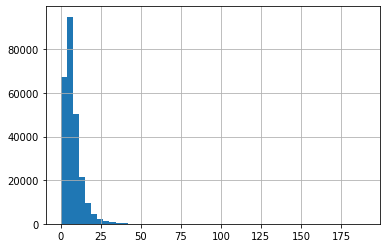

In [16]:
oof['error'].hist(bins=50)

(0.0, 200.0)

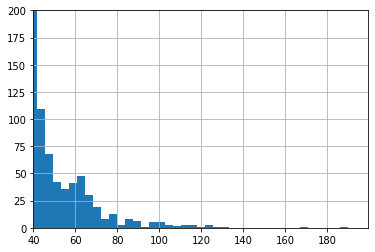

In [17]:
oof['error'].hist(bins=50)
plt.xlim(40,)
plt.ylim(0,200)

かなり外れているのもある
40以上の外れ値ってどうなっているの？どういうpathが存在している？

In [18]:
oof.loc[oof['error']>40, 'path']  # このpath消すってのもありかも

8544      5e15ab811506f2000638fe0d
536       5d11943f9c50c70008fe8999
704       5d11dbb7ffe23f0008604f35
908       5d11dbc8ffe23f0008604f49
6         5d10a1669c50c70008fe8977
                    ...           
238477    5dccedae757dea0006080310
238476    5dccedae757dea0006080310
252071    5dd79faf9191710006b567b1
242083    5dcd26cca4dbe7000630ae50
244028    5dcd5c89a4dbe7000630b086
Name: path, Length: 544, dtype: object

In [19]:
oof.loc[oof['error']>40, 'path'].nunique()

135

In [20]:
oof.loc[oof['error']>40, 'path'].value_counts().values  # 数はどれくらい

array([41, 40, 27, 19, 19, 13, 12, 12, 12, 10, 10, 10,  9,  9,  8,  8,  8,
        8,  8,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  5,  5,  5,  5,  5,
        4,  4,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

pathごとに見てみると同一pathで全体的に外しているものが10個くらいある。path内のデータのうちどれくらいのデータが40オーバーになっているか調査する

<AxesSubplot:>

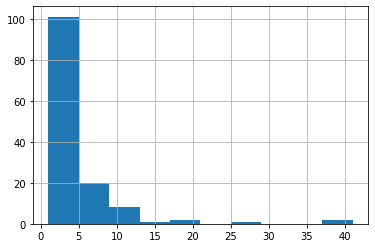

In [21]:
oof.loc[oof['error']>40, 'path'].value_counts().hist()

In [22]:
path = oof.loc[oof['error']>40, 'path'].value_counts().index
num_data_over40 = oof.loc[oof['error']>40, 'path'].value_counts().values
num_data = []
for i in path:
    num_data.append(len(oof[oof['path']==i]))

(array([99., 20.,  3.,  3.,  2.,  2.,  0.,  1.,  0.,  5.]),
 array([0.00205761, 0.10185185, 0.20164609, 0.30144033, 0.40123457,
        0.50102881, 0.60082305, 0.70061728, 0.80041152, 0.90020576,
        1.        ]),
 <BarContainer object of 10 artists>)

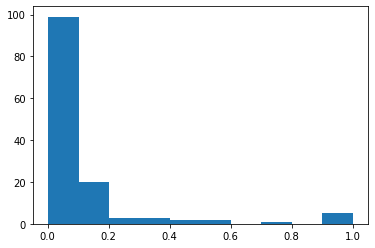

In [23]:
plt.hist(num_data_over40 / num_data)

path丸ごと外しているものもある

In [24]:
import json
import matplotlib.pylab as plt

def plot_preds(
    example,
    base=str(root_dir /'indoor-location-navigation'),
):
    """
    Plots predictions on floorplan map.
    
    map_floor : use a different floor's map
    """
    site = example.loc[0, 'site_id_str']
    map_floor = example.loc[0, 'floor_str']
    path = example.loc[0, 'path']
    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_image.png"
    json_plan_filename = f"{base}/metadata/{site}/{map_floor}/floor_info.json"
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    floor_img = plt.imread(f"{base}/metadata/{site}/{map_floor}/floor_image.png")

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_title(f'site={site} | floor={map_floor} | path={path}', fontsize=15)
    plt.imshow(floor_img)


    example["x_"] = example["x"] * floor_img.shape[0] / height_meter
    example["y_"] = (example["y"] * -1 * floor_img.shape[1] / width_meter) + floor_img.shape[0]


    example["oof_x_"] = example["oof_x"] * floor_img.shape[0] / height_meter
    example["oof_y_"] = (example["oof_y"] * -1 * floor_img.shape[1] / width_meter) + floor_img.shape[0]

    example.plot(
        x="x_",
        y="y_",
        style=".-",
        ax=ax,
        alpha=0.5,
        label='target'
    )
    example.plot(
        x="oof_x_",
        y="oof_y_",
        style=".-",
        ax=ax,
        alpha=0.5,
        label='oof'
    )
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(
        by_label.values(), by_label.keys(), loc="center left", bbox_to_anchor=(1, 0.5),fontsize=20
    )
    return fig, ax

In [25]:
np.where((num_data_over40 / num_data) > 0.5)  # 半分以上おかしいものを取得

(array([ 0,  2,  4, 15, 19, 20, 21, 26]),)

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'site=5da1383b4db8ce0c98bc11ab | floor=F1 | path=5dd5216b50e04e0006f56476'}, xlabel='oof_x_'>)

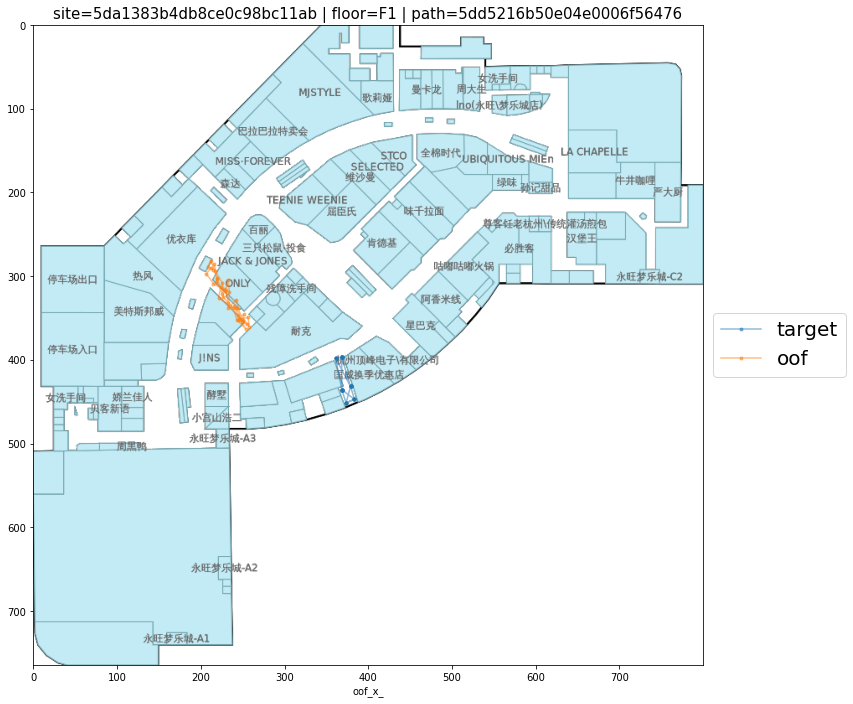

In [26]:
example = oof[oof['path']==path[0]].reset_index()
plot_preds(example)

In [27]:
df = pd.merge(oof.groupby('site_path_timestamp').mean(), train_df.groupby('site_path_timestamp')[['timediff']].mean(), how='left', on='site_path_timestamp')

Text(0, 0.5, 'error')

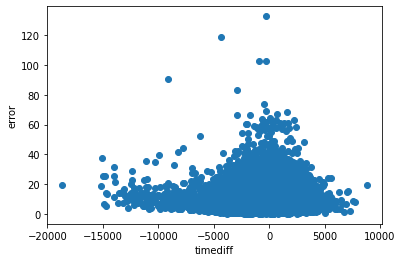

In [26]:
x = df['timediff']
y = df['error']
plt.scatter(x,y)
plt.xlabel('timediff')
plt.ylabel('error')